<a href="https://colab.research.google.com/github/pragya79/Indian-Cuisine-Classification-VGG16-ResNet50-/blob/main/Mobilenet_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
!nvidia-smi

Wed Jul 24 05:35:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0              33W /  70W |   2173MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
path='/content/drive/MyDrive/food_dataset'

In [20]:
#removing the corrupted images
from PIL import Image

def check_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Bad file: {file_path}")
                os.remove(file_path)

dataset_path = '/content/drive/MyDrive/food_dataset'
check_images(dataset_path)


In [21]:
import tensorflow as tf
from tensorflow import keras

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

**DATA AUGMENTATION**

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

In [6]:
train_gen=train_datagen.flow_from_directory(
    path,
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    subset='training',
    shuffle=True
)

Found 2694 images belonging to 20 classes.


In [7]:
validation_gen=train_datagen.flow_from_directory(
    path,
    target_size=(224,224),
    class_mode='sparse',
    batch_size=32,
    subset='validation',
    shuffle=True
)

Found 1144 images belonging to 20 classes.


In [8]:
print(train_gen.class_indices)
print(validation_gen.class_indices)


{'Aloo Puri': 0, 'Bhindi Masala': 1, 'Chhole Bhature': 2, 'Dal Bati Churma': 3, 'Dal Makhni': 4, 'Dhokla': 5, 'Gulab Jamun': 6, 'Idli Sambhar': 7, 'Jalebi': 8, 'Kheer': 9, 'Mushroom': 10, 'Paneer': 11, 'Pav Bhaji': 12, 'Poha': 13, 'Rajma Chawal': 14, 'Rasgulla': 15, 'Rasmalai': 16, 'Sarson ka Saag Makki ki Roti': 17, 'Thepla': 18, 'Vada Pav': 19}
{'Aloo Puri': 0, 'Bhindi Masala': 1, 'Chhole Bhature': 2, 'Dal Bati Churma': 3, 'Dal Makhni': 4, 'Dhokla': 5, 'Gulab Jamun': 6, 'Idli Sambhar': 7, 'Jalebi': 8, 'Kheer': 9, 'Mushroom': 10, 'Paneer': 11, 'Pav Bhaji': 12, 'Poha': 13, 'Rajma Chawal': 14, 'Rasgulla': 15, 'Rasmalai': 16, 'Sarson ka Saag Makki ki Roti': 17, 'Thepla': 18, 'Vada Pav': 19}


OUTPUT SHAPES OF DATA GENERATORS

In [ ]:
batch_x, batch_y = next(train_gen)
print(f"Shape of batch_x: {batch_x.shape}")
print(f"Shape of batch_y: {batch_y.shape}")

In [9]:
from tensorflow.keras import layers,models
from tensorflow.keras.applications import ResNet50,MobileNetV2

In [10]:
reference_model=MobileNetV2(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


**Tranfer Learning**

In [11]:
# freezing the layers
for layer in reference_model.layers:
    layer.trainable=False

In [22]:
model = models.Sequential([
    reference_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(units=128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=20, activation='softmax')
])

In [13]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']

)

In [26]:
print(layer,layer.trainable)

<keras.src.layers.activation.relu.ReLU object at 0x7c9e7027b460> False


**Fine Tuning**

In [ ]:
# Unfreezing some layers
for layer in reference_model.layers[:]:  #last all layers are unfreezed now
    layer.trainable = True

model.compile(
        tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9),#taking lower learning_rate for fine tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

In [ ]:
print(layer,layer.trainable)

In [ ]:
# !pip install scikeras

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from scikeras.wrappers import KerasClassifier

# def model_creation(learning_rate=0.1, optimizer='adam', dropout_rate=0.3):
#   model=models.Sequential([
#       reference_model,
#       layers.Flatten(),
#       layers.BatchNormalization(),
#       layers.Dense(units=256, activation='relu'),
#       layers.BatchNormalization(),
#       layers.Dropout(dropout_rate),
#       layers.Dense(units=35, activation='softmax')
#   ])
#   if optimizer=='adam':
#     optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
#   else:
#     optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate)

#   model.compile(
#       optimizer=optimizer,
#       loss='categorical_crossentropy',
#       metrics=['accuracy']
#   )
#   return model


# classifier=KerasClassifier(build_fn=model_creation,verbose=1,batch_size=32,epochs=40)

# param_dic = {
#       'model__learning_rate': [0.0001, 0.001, 0.01,0.1],
#       'model__optimizer': ['adam', 'sgd'],
#       'model__dropout_rate': [0.3, 0.5, 0.7],
#       'batch_size': [16,32, 64],
#       'epochs': [20, 40],
# }
# randomCV_object=RandomizedSearchCV(
#     estimator=classifier,
#     param_distributions=param_dic,
#     cv=5
# )
# randomCV_object.fit(train_gen,validation_gen)

# print(f"Best parameters: {randomCV_object.best_params_}")
# print(f"Best score: {randomCV_object.best_score_}")



In [16]:
steps_per_epoch=train_gen.samples,
validation_steps=validation_gen.samples

In [17]:
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/saved_model/model_epoch_{epoch:02d}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_freq='epoch',
)

In [27]:
trained_model=model.fit(
    train_gen,
    epochs=10,
    validation_data=validation_gen,
    # steps_per_epoch=len(train_gen),
    # validation_steps=len(validation_gen),
    # callbacks=[checkpoint_callback]
)

Epoch 1/10
30/85 [=========>....................] - ETA: 30s - loss: 1.6956 - accuracy: 0.5208

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


85/85 [==============================] - 83s 936ms/step - loss: 1.2460 - accuracy: 0.6422 - val_loss: 1.0757 - val_accuracy: 0.7273
Epoch 2/10
85/85 [==============================] - 69s 816ms/step - loss: 0.1729 - accuracy: 0.9774 - val_loss: 0.8590 - val_accuracy: 0.7552
Epoch 3/10
85/85 [==============================] - 69s 820ms/step - loss: 0.0577 - accuracy: 0.9978 - val_loss: 0.8410 - val_accuracy: 0.7552
Epoch 4/10
85/85 [==============================] - 70s 822ms/step - loss: 0.0266 - accuracy: 0.9993 - val_loss: 0.8282 - val_accuracy: 0.7657
Epoch 5/10
85/85 [==============================] - 68s 806ms/step - loss: 0.0185 - accuracy: 0.9996 - val_loss: 0.8367 - val_accuracy: 0.7649
Epoch 6/10
85/85 [==============================] - 70s 825ms/step - loss: 0.0109 - accuracy: 0.9996 - val_loss: 0.8370 - val_accuracy: 0.7649
Epoch 7/10
85/85 [==============================] - 70s 827ms/step - loss: 0.0106 - accuracy: 0.9996 - val_loss: 0.8666 - val_accuracy: 0.7605
Epoch 8/10

**Saving the Model as .h5 file**

In [29]:
saved_model=model.save('/content/drive/MyDrive/saved_model/final.keras')

In [30]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/saved_model/final.keras')

In [ ]:
# model.fit(
#     train_gen,
#     epochs=20,
#     validation_data=validation_gen,
#     steps_per_epoch=len(train_gen),
#     validation_steps=len(validation_gen),
#     callbacks=[early_stopping]
# )

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 batch_normalization_2 (Bat  (None, 62720)             250880    
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               8028288   
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                      

In [32]:
y_predict=model.predict(validation_gen)

36/36 [==============================] - 21s 566ms/step


In [33]:
model.evaluate(validation_gen)

36/36 [==============================] - 28s 757ms/step - loss: 0.8684 - accuracy: 0.7579


[0.8683524131774902, 0.757867157459259]

In [34]:
from sklearn.metrics import classification_report
y_true=validation_gen.classes #20 classes
print(classification_report(y_true,y_predict.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.03      0.02      0.03        46
           1       0.06      0.07      0.06        72
           2       0.07      0.08      0.07        79
           3       0.08      0.08      0.08        91
           4       0.08      0.07      0.07        46
           5       0.09      0.09      0.09        97
           6       0.04      0.04      0.04        51
           7       0.07      0.07      0.07        90
           8       0.02      0.03      0.02        77
           9       0.05      0.05      0.05        60
          10       0.03      0.02      0.02        63
          11       0.09      0.12      0.10       100
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00         4
          14       0.09      0.09      0.09        91
          16       0.00      0.00      0.00         1
          17       0.06      0.06      0.06        90
          18       0.08    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
import matplotlib.pyplot as plt

In [39]:
training_loss=trained_model.history['loss']
test_loss=trained_model.history['val_loss']#loss on validation dataset
training_acc=trained_model.history['accuracy']#accuracy on training dataset
test_acc=trained_model.history['val_accuracy']#accuracy on validation dataset
epochs=range(len(training_loss))

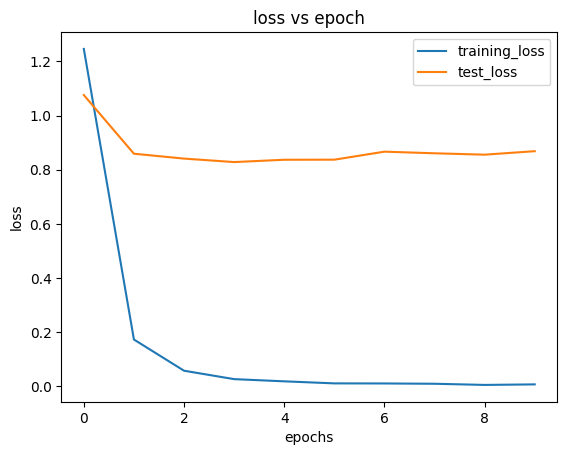

In [41]:
#ploting epoch vs training_loss & epoch vs test_loss graph

plt.title('loss vs epoch')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs,training_loss,label='training_loss')
plt.plot(epochs,test_loss,label='test_loss')
plt.legend()
plt.show()


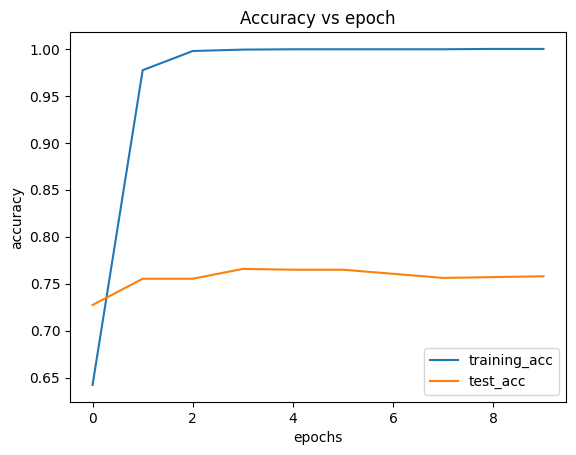

In [43]:
#ploting epoch vs tarining_acc & epoch vs test_acc graph
plt.title('Accuracy vs epoch')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(epochs,training_acc,label='training_acc')
plt.plot(epochs,test_acc,label='test_acc')
plt.legend()
plt.show()

Using the Saved model to predict new images as one of the classes

In [44]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
#function to predict images
def predict_image(image_path,saved_model):
  img=image.load_img(image_path,target_size=(224,224))
  img=image.img_to_array(img)
  img=img/255.0

  img=np.expand_dims(img,axis=0)

  prediction=saved_model.predict(img)
  classes = ['Aloo Puri', 'Bhindi Masala', 'Chhole Bhature', 'Dal Bati Churma', 'Dal Makhni', 'Dhokla', 'Gulab Jamun', 'Idli Sambhar', 'Jalebi', 'Kheer', 'Mushroom', 'Paneer', 'Pav Bhaji', 'Poha', 'Rajma Chawal', 'Rasgulla', 'Rasmalai', 'Sarson ka Saag Makki ki Roti', 'Thepla', 'Vada Pav']

  predicted_class=classes[np.argmax(prediction)]

  return predicted_class



In [45]:
saved_model=load_model('/content/drive/MyDrive/saved_model/final.keras')
image_path='/content/drive/MyDrive/new.jfif'
predicted_class=predict_image(image_path,saved_model)
print(predicted_class)

1/1 [==============================] - 1s 1s/step
Jalebi
